In [1]:
##################################################
########## Loading Necessary Libraries  ##########
##################################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp
p = mp.Pool(mp.cpu_count())
%matplotlib inline

from numpy.linalg import inv
import time

In [2]:
##################################################
########### Loading and Cleaning Data ############
##################################################

# # Load data
data = pd.read_csv('data.csv')

# Extracting the target variable for final accuracy calculation
y = data['diagnosis']

##### Preprocessing the data #####
X = data.drop(['id', 'diagnosis','Unnamed: 32'], axis=1)

# Cleaning the data 
corr = X.corr()
corr_t = corr.abs().unstack()
corr_t = corr_t.sort_values(kind="quicksort")
col_to_drop = []
for i in range(1, len(corr_t)):
    if corr_t[i] > 0.9 and corr_t.index[i][0] != corr_t.index[i][1]:
        col_to_drop.append([corr_t.index[i][0], corr_t.index[i][1]])
# Calculate total correlation of each column in col_to_drop
total_corrs = corr.abs().sum(axis=1).sort_values(ascending=False)
droped_cols = []
for i in col_to_drop:
    if(i[0] in droped_cols or i[1] in droped_cols):
        continue
    elif total_corrs[i[0]] > total_corrs[i[1]]:
        X.drop(i[1], axis=1, inplace=True)
        droped_cols.append(i[1])
    else:
        X.drop(i[0], axis=1, inplace=True)
        droped_cols.append(i[0])

##### Cleaning and standardizing the data #####
y = data['diagnosis']
df_Y = pd.DataFrame(y)
df_Y['diagnosis'] = df_Y['diagnosis'].apply(lambda x: 1 if x == 'M' else 2)
y = df_Y

max_correlation = 5
corr = X.corr()
# Choose the highest correlation columns
highest_corr_col = corr.abs().sum(axis=1).sort_values(ascending=False).head(1)
while(highest_corr_col[0] > max_correlation):
    # Drop the highest correlation columns
    X = X.drop(highest_corr_col.index, axis=1)
    corr = X.corr()
    highest_corr_col = corr.abs().sum(axis=1).sort_values(ascending=False).head(1)

# convert y as df to a np.array
np_y = np.array(y)

# Get the length of y
np_y_n = len(np_y)

In [3]:
class GeneticAlgorithmMCC:
    def __init__(self, population_size, max_generation, mutation_rate, crossover_rate, X, y):
        self.population_size = population_size
        self.max_generation = max_generation
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.entropies = {}
        self.y = y
        self.X = X
        self.X.columns = [i+1 for i in range(len(self.X.columns))]
        self.X[0] = 1
        self.X = self.X.reindex(list(self.X.columns.sort_values()), axis=1)

    def calculate_R2(self, df_Y):
        XT = self.X.T.reset_index(drop=True)
        
        b = inv(XT @ self.X) @ XT @ df_Y
        bT = b.T.reset_index(drop=True)

        temp1 = bT @ XT @ df_Y
        SS = (temp1 - (1/len(self.X))*((self.X.T@df_Y)**2))
        SS_error = (df_Y.T @ df_Y) - (temp1)
        R2 = SS/ (SS + SS_error)

        return SS[0][0], SS_error[0][0], R2[0][0]

    def create_population(self):
        # Unique values of y
        values = self.y.diagnosis.unique()

        # Create a list to store the population
        population = pd.DataFrame(columns=['individual'])

        # A for loop to create the population
        for i in range(self.population_size):
            # Create a random individual
            individual = np.random.choice(values, size=len(self.y))
            # Append the individual to the population
            population = pd.concat([population, pd.DataFrame([{ 'individual': individual }])], ignore_index=True)

        # Return the population
        return population

    def calculate_R2_score_apply(self, individual):
        # Calculate the R2 Score of the individual
        _, _, r2_score = self.calculate_R2(pd.DataFrame(individual))

        return r2_score

    def calculate_fitness(self, population):
        # Create a list to store the fitness
        # population['fitness'] = population['individual'].apply(self.calculate_R2_score_apply)
        population['fitness'] = p.map(self.calculate_R2_score_apply, population['individual'])

        # Return the fitness
        return population

    def select_parents(self, population):
        # Select the parents
        parents = np.random.choice(len(population), size=2, replace=False, p=probability)
        
        # Return the parents
        return population['individual'][parents[0]], population['individual'][parents[1]]

    def crossover(self, parent1, parent2):
        # Create a random number for the crossover
        crossover = np.random.random()

        # Check if the crossover is less than the crossover rate
        if crossover < self.crossover_rate:
            # Create a random number for the crossover point
            crossover_point = np.random.randint(0, len(parent1))

            temp_parent1 = parent1
            temp_parent2 = parent2

            # Create a child 1
            child1 = np.concatenate((temp_parent1[:crossover_point], temp_parent2[crossover_point:]))
            # Create a child 2
            child2 = np.concatenate((temp_parent2[:crossover_point], temp_parent1[crossover_point:]))

            # Return the children
            return child1, child2

        # Return the parents
        return parent1, parent2

    def mutation(self, child):
        # Create a random number for the mutation
        mutation = np.random.random()

        # Check if the mutation is less than the mutation rate
        if mutation < self.mutation_rate:
            # Create a random number for the mutation point
            mutation_point = np.random.randint(0, len(child))

            temp_child = child

            # Create a list of unique values
            unique_values = np.unique(temp_child)
            # Remove current value from unique values
            unique_values = np.delete(unique_values, np.where(unique_values == temp_child[mutation_point]))
            
            temp_child[mutation_point] = np.random.choice(unique_values)

            # Return the child
            return temp_child

        # Return the child
        return child

    def select_parent_individually(self, population):
        # Select the parent
        parent = np.random.choice(len(population), size=1, replace=False, p=population['probability'])
        
        # Return the parents
        return population['individual'][parent[0]]

    def run_genetic_algorithm(self):
        ##### Running the genetic algorithm #####

        # Create initial population
        population = self.create_population()
        # Creating fields to store all time best and its fitness
        all_time_best = []
        all_time_best_fitness = 0
        all_time_database = pd.DataFrame()

        # Create a for loop to run the genetic algorithm
        for i in range(0, self.max_generation):
            print("Generation " + str(i+1) + " ...   ", end="\r")

            # Calculate the fitness of the population
            population = self.calculate_fitness(population)

            # Check if the fitness of the population is greater than the all time best fitness
            max_index = population['fitness'].idxmax()
            if population['fitness'][max_index] > all_time_best_fitness:
                all_time_best_fitness = population['fitness'][max_index]
                all_time_best = population['individual'][max_index]

            # Add population and fitness to all_time_database
            all_time_database = pd.concat([all_time_database, population], ignore_index=True)

            population['probability'] = population['fitness'] / sum(population['fitness'])
            
            # Create a list to store the new population
            # new_population = pd.DataFrame(columns=['individual'])

            new_population = pd.DataFrame(columns=['individual'])
            new_population['individual'] = pd.Series([self.select_parent_individually(population) for i in range(0, self.population_size)])

            # Apply Crossover
            for j in range(0, int(self.population_size/2)):
                # Crossover
                child1, child2 = self.crossover(new_population['individual'][j*2], new_population['individual'][j*2+1])
                # Add child1 and child2 to new_population
                new_population['individual'][j*2] = child1
                new_population['individual'][j*2+1] = child2

            # Apply Mutation
            # new_population['individual'] = new_population['individual'].apply(self.mutation)
            new_population['individual'] = p.map(self.mutation, new_population['individual'])

            population = new_population

        # Return the all time best and its fitness
        return all_time_best, all_time_best_fitness, all_time_database

##############################################
##### Functions for Calculating Accuracy #####
##############################################

def calculate_accuracy(predicted_y):
    # Create a for loop to calculate accuracy
    accuracy = 0
    for i in range(0, np_y_n):
        if np_y[i] == predicted_y[i]:
            accuracy = accuracy + 1

    # Return accuracy
    return accuracy/np_y_n

##############################################
########### Defining Run Function ############
##############################################

#Function to run the genetic algorithm with multiple configurations
def multi_run(run_configuration):
    all_individuals = pd.DataFrame(columns=['individual', 'fitness', 'accuracy', 'run'])

    # Create a list to store the accuracy
    results = []
    print("Running the genetic algorithm, for " + str(len(run_configuration)) + " runs ...")
    # A for loop to run the genetic algorithm multiple times
    for i in range(0, len(run_configuration)):
        print("Run " + str(i+1) + " ...          ")

        # Set start time
        start_time = time.time()

        # Run the genetic algorithm
        gen_algo = GeneticAlgorithmMCC(run_configuration[i]['population_size'], run_configuration[i]['max_generation'], run_configuration[i]['mutation_rate'], run_configuration[i]['crossover_rate'], X, y)
        all_time_best, all_time_best_fitness, all_time_database = gen_algo.run_genetic_algorithm()

        # Accuracy calculation
        accuracy = calculate_accuracy(all_time_best)

        mid_time = time.time()

        # Go through the all_time_database to get all the individuals, if the individual is not in all_individuals, add it to all_individuals with its fitness and calculated accuracy)
        # all_time_database['accuracy'] = all_time_database['individual'].apply(calculate_accuracy)
        all_time_database['accuracy'] = p.map(calculate_accuracy, all_time_database['individual'])
        all_time_database['run'] = i
        all_individuals = pd.concat([all_individuals, all_time_database], ignore_index=True)

        # Set end time
        first_half_time = mid_time - start_time
        second_half_time = time.time() - mid_time

        # update the results, append the configuration and the accuracy, destructure the configuration
        results.append({
            **run_configuration[i],
            'accuracy': accuracy,
            'all_time_best': all_time_best,
            'all_time_best_fitness': all_time_best_fitness,
            'first_half_time': first_half_time,
            'second_half_time': second_half_time
        })
    print("Done!                              ")
    # Return the accuracy
    return results, all_individuals


#### VERY IMPORTANT NOTE

Please note that due to an issue with multiprocessing library, the next code block should be ran twice and stop it manually to work for the rest of the runs. I have tried some of the work around (like moving the functions of Pool.map to an external file), but because of some data access and other issues (like being unable to pass other parameter's to the function) I was unable to make it work.

In [5]:
##################################################
################## Run the code ##################
##################################################

run_configuration = [
    {
        'population_size': 300,
        'max_generation': 2000,
        'mutation_rate': 0.2,
        'crossover_rate': 0.8
    },
    {
        'population_size': 300,
        'max_generation': 2000,
        'mutation_rate': 0.3,
        'crossover_rate': 0.8
    },
    {
        'population_size': 300,
        'max_generation': 2000,
        'mutation_rate': 0.4,
        'crossover_rate': 0.8
    },
]

results, all_individuals = multi_run(run_configuration)

# Set the test time end
test_time_end = time.time()

Running the genetic algorithm, for 3 runs ...
Run 1 ...          
Run 2 ...             
Run 3 ...             
Done!                              


In [6]:
##################################################
############ Processing results data #############
##################################################

# Export run_configuration to a csv file
run_configuration_df = pd.DataFrame(run_configuration)
run_configuration_df.to_csv('MCC-run_configuration-' + time.strftime("%Y-%m-%d-%H:%M:%S", time.localtime(test_time_end)) + '.csv', index=False)

# Create a chart to show the results
results_df = pd.DataFrame(results)
results_df = results_df.drop(['all_time_best'], axis=1)
results_df = results_df.sort_values(by=['accuracy'], ascending=False)
results_df = results_df.reset_index(drop=True)

# Export the results to a csv file
results_df.to_csv('MCC-results-' + time.strftime("%Y-%m-%d-%H:%M:%S", time.localtime(test_time_end)) + '.csv', index=False)

# Display the results
results_df

,population_size,max_generation,mutation_rate,crossover_rate,accuracy,all_time_best_fitness,first_half_time,second_half_time
0,300,2000,0.2,0.8,0.497364,1.088291,2064.696440,73.208443
1,300,2000,0.3,0.8,0.485062,1.088407,2070.516549,71.867260
2,300,2000,0.4,0.8,0.467487,1.090644,2054.597966,72.579257


Total number of unique individuals: 1800000


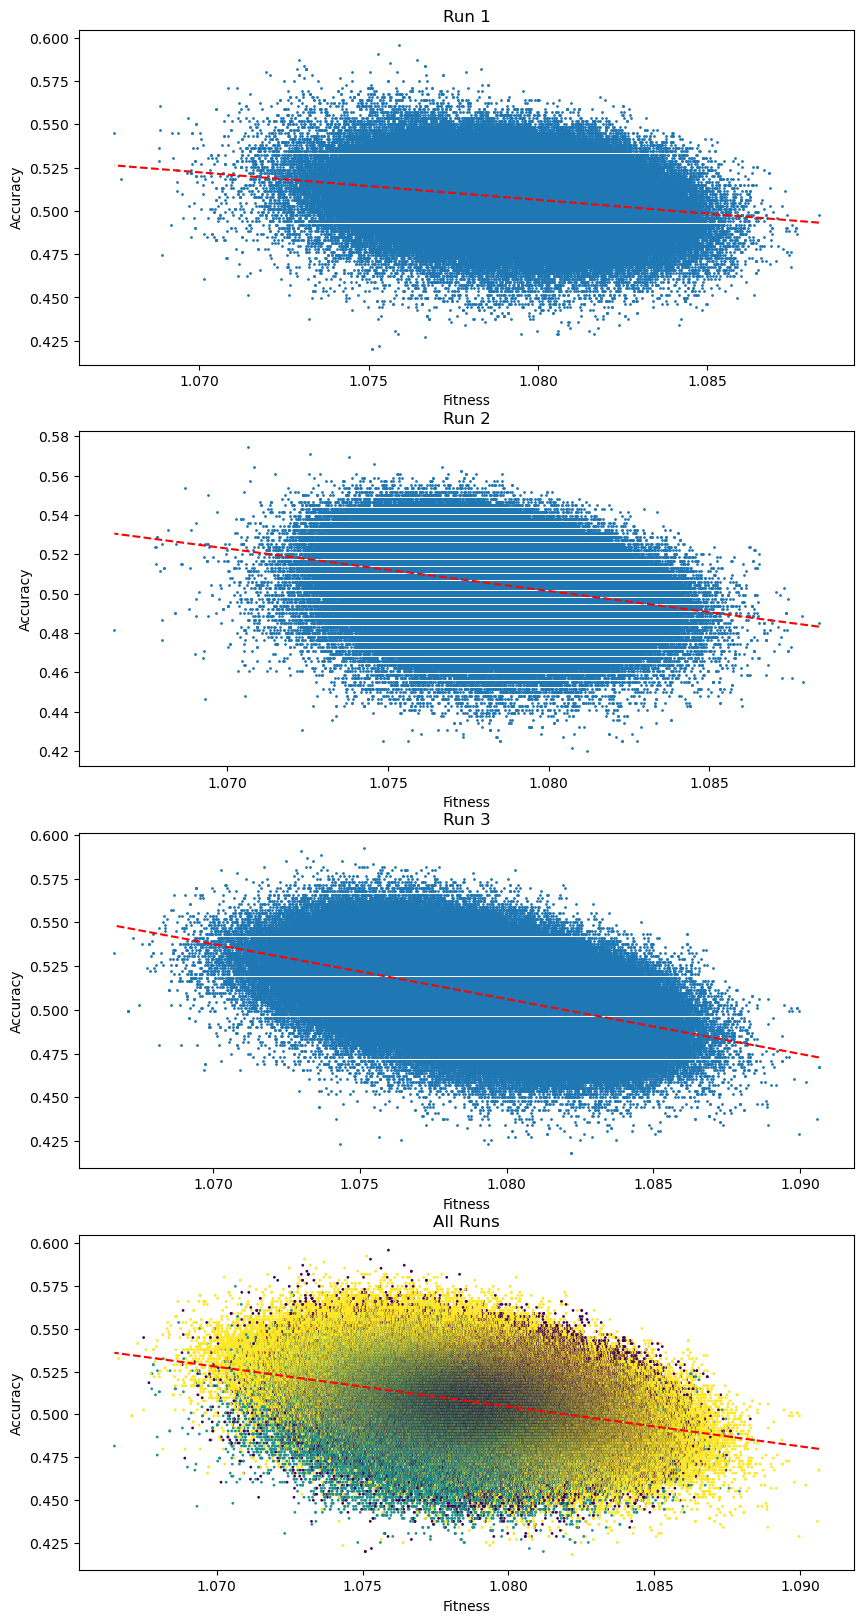

In [7]:
##################################################
########### Plotting all_individuals #############
##################################################

# Create a chart to show all_individuals with their fitness and accuracy as axes
all_individuals = all_individuals.reset_index(drop=True)

# Export the all_individuals to a csv file
all_individuals.to_csv('MCC-all_individuals_list-' + time.strftime("%Y-%m-%d-%H:%M:%S", time.localtime(test_time_end)) + '.csv', index=False)

# Print total number of unique individuals
print("Total number of unique individuals: " + str(len(all_individuals)))

# Plot all_individuals and fit a line, colorized by number of run

fig, axs = plt.subplots(len(run_configuration) + 1, 1, figsize=(10, 20))

for i in range(len(run_configuration)):
    axs[i].scatter(all_individuals[all_individuals['run'] == i]['fitness'], all_individuals[all_individuals['run'] == i]['accuracy'], s=1)
    z = np.polyfit(all_individuals[all_individuals['run'] == i]['fitness'], all_individuals[all_individuals['run'] == i]['accuracy'], 1)
    p = np.poly1d(z)
    axs[i].plot(all_individuals[all_individuals['run'] == i]['fitness'], p(all_individuals[all_individuals['run'] == i]['fitness']), "r--")
    axs[i].set_xlabel('Fitness')
    axs[i].set_ylabel('Accuracy')
    axs[i].set_title('Run ' + str(i+1))

# Plotting all runs
axs[len(run_configuration)].scatter(all_individuals['fitness'], all_individuals['accuracy'], c=all_individuals['run'], s=1)
z = np.polyfit(all_individuals['fitness'], all_individuals['accuracy'], 1)
p = np.poly1d(z)
axs[len(run_configuration)].plot(all_individuals['fitness'], p(all_individuals['fitness']), "r--")
axs[len(run_configuration)].set_xlabel('Fitness')
axs[len(run_configuration)].set_ylabel('Accuracy')
axs[len(run_configuration)].set_title('All Runs')

# Export the plot to a png file, name: all_individuals-DATE-TIME.png
plt.savefig('MCC-all_individuals_chart-' + time.strftime("%Y-%m-%d-%H:%M:%S", time.localtime(test_time_end)) + '.png')
